In [1]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

def read_transcription(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def create_dataframe(dialogue_id, transcription):
    rows = []

    # Iterate through all sentences in the transcription
    for index, sentence in enumerate(transcription):
        speaker = sentence['speaker']

        # Get the sentence text
        text = sentence['text']

        # Add a row to the DataFrame
        rows.append({
            'dialogue_id': dialogue_id,
            'index': index,
            'text': text,
            'speaker_text': speaker,
        })

    # Create the DataFrame
    df = pd.DataFrame(rows)

    return df

# Function to get labels for a dialogue
def get_label(dialogue_id, index,labels_data):
    return labels_data.get(dialogue_id, [])[index]

In [3]:
# Remplacez 'votre_chemin' par le chemin correct
path_train= Path("data/training")
path_test= Path("data/test")

# Remplacez 'vos_dialogue_ids' par votre liste réelle d'identifiants de dialogue
training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
training_set.remove('IS1002a')
training_set.remove('IS1005d')
training_set.remove('TS3012c')

test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])

In [4]:
# Créer le DataFrame pour l'ensemble d'entraînement
dfs = []
for dialogue_id in training_set:
    transcription_data = read_transcription(path_train / f'{dialogue_id}.json')
    df = create_dataframe(dialogue_id, transcription_data)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# Ajouter la colonne 'label' à df en utilisant la fonction get_label
with open("data/training_labels.json", 'r') as file:
    labels_data = json.load(file)

df['label'] = df.apply(lambda row: get_label(row['dialogue_id'], row['index'], labels_data), axis=1)

# Créer le DataFrame pour l'ensemble de test
dfs_test = []
for dialogue_id in test_set:
    transcription_data = read_transcription(path_test / f'{dialogue_id}.json')
    df_test = create_dataframe(dialogue_id, transcription_data)
    dfs_test.append(df_test)

df_test = pd.concat(dfs_test, ignore_index=True)

In [9]:
for i in df[df.label == 1]['text']:
    print(i)
    

<vocalsound> Um well this is the kick-off meeting for our our project .
so we're designing a new remote control and um <disfmarker>
Um , as you can see it's supposed to be original , trendy and user friendly .
Um and so there are three different stages to the design .
So we're gonna have like individual work and then a meeting about it .
And repeat that process three times .
<vocalsound> So uh you get to draw your favourite animal and sum up your favourite characteristics of it .
My favourite animal is like <disfmarker>
A beagle .
Uh , right , well basically um high priority for any animal for me is that they be willing to take a lot of physical affection from their family .
And , yeah that they have lots of personality
Well , my favourite animal would be a monkey .
Then they're small cute and furry ,
and I kind of like whales .
They come in and go <vocalsound> eat everything in sight . <vocalsound>
M my favourite animal is my own dog at home .
Um he's very friendly and cheery and alwa

In [19]:
df['bert'] = df['text']
for transcription_id in training_set:
    bert_array = np.load('feature-extraction/bert/training/' + transcription_id + '.npy')
    
    # Obtenez les indices des lignes correspondant à la transcription_id
    indices = df[df['dialogue_id'] == transcription_id].index
    
    # Remplacez les valeurs de la colonne 'text' par les valeurs de bert_array
    for idx, value in enumerate(bert_array):
        df.at[indices[idx-1], 'bert'] = value

df_test['bert'] = df_test['text']
for transcription_id in test_set:
    bert_array_test = np.load('feature-extraction/bert/test/' + transcription_id + '.npy')
    
    # Obtenez les indices des lignes correspondant à la transcription_id
    indices = df_test[df_test['dialogue_id'] == transcription_id].index
    
    # Remplacez les valeurs de la colonne 'text' par les valeurs de bert_array
    for idx, value in enumerate(bert_array_test):
        df_test.at[indices[idx-1], 'bert'] = value


In [20]:
# Nombre d'éléments dans chaque liste
num_elements = len(df['bert'].iloc[0])

# Créez de nouvelles colonnes pour chaque élément dans la liste
new_columns = [f'coord_{i}' for i in range(num_elements)]

# Appliquez une fonction qui divise chaque liste en plusieurs colonnes
new_text_columns = df['bert'].apply(pd.Series)

# Renommez les nouvelles colonnes avec les noms spécifiques
new_text_columns.columns = new_columns

# Concaténez les nouvelles colonnes avec le DataFrame existant
df = pd.concat([df, new_text_columns], axis=1)


# Nombre d'éléments dans chaque liste
num_elements = len(df_test['bert'].iloc[0])

# Appliquez une fonction qui divise chaque liste en plusieurs colonnes
new_text_columns_test = df_test['bert'].apply(pd.Series)

# Renommez les nouvelles colonnes avec les noms spécifiques
new_text_columns_test.columns = new_columns

# Concaténez les nouvelles colonnes avec le DataFrame existant
df_test = pd.concat([df_test, new_text_columns_test], axis=1)


In [21]:
df['nb_words_more_5'] = df['text'].apply(lambda x: sum(len(mot) > 5 and mot.lower() != '<vocalsound>' for mot in x.split()))

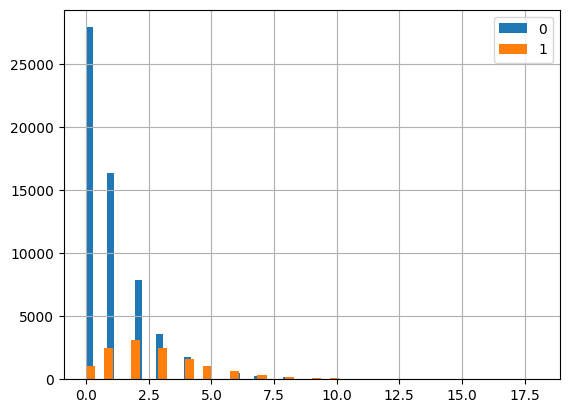

In [22]:
df[df['label'] == 0]['nb_words_more_5'].hist(bins=50, label='0')
df[df['label'] == 1]['nb_words_more_5'].hist(bins=50, label='1')
plt.legend()
plt.show()

In [11]:
df['word_count'] = df['text'].apply(lambda x: len(x.split(' ')))

In [12]:
df.head(2)

,dialogue_id,index,text,speaker_text,label,bert,coord_0,coord_1,coord_2,coord_3,...,coord_376,coord_377,coord_378,coord_379,coord_380,coord_381,coord_382,coord_383,nb_long_words,word_count
0,ES2002a,0,Okay,PM,0,"[-0.054861926, 0.047606602, -0.032625835, -0.0...",-0.054862,0.047607,-0.032626,-0.010949,...,-0.021490,0.007297,0.027587,0.027128,0.145950,0.037911,0.073511,0.079932,0,1
1,ES2002a,1,Right,PM,0,"[-0.054665036, -0.073837034, -0.017160872, -0....",-0.054665,-0.073837,-0.017161,-0.064276,...,-0.025984,0.077994,0.003580,0.032260,0.022304,0.059096,-0.036019,-0.008820,0,1


In [25]:
X = df.drop(['dialogue_id','text','speaker_text','bert','label'],axis=1)
y = df[['label']]

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import f1_score

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [39]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

In [41]:
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [42]:
epochs = 5
batch_size = 32

for epoch in range(epochs):
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.view(-1, 1))
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 1/5, Loss: 0.16609567403793335
Epoch 2/5, Loss: 0.18858137726783752
Epoch 3/5, Loss: 0.19925375282764435
Epoch 4/5, Loss: 0.19970043003559113
Epoch 5/5, Loss: 0.20735599100589752


In [37]:
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    predictions = model(X_test_tensor)
    predictions = (predictions >= 0.5).float()
    accuracy = torch.sum(predictions == y_test.view(-1, 1)).item() / len(y_test)
    print(f'Accuracy: {accuracy}')
    f1 = f1_score(y_test, predictions)
    print(f'F1-score: {f1}')

Accuracy: 0.4376592082616179
F1-score: 0.2663912340578408


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [16]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Ajuster la forme des données
X_train = X_train.values.reshape(-1, len(X.columns))
X_test = X_test.values.reshape(-1, len(X.columns))

In [17]:
# Initialiser le modèle
model = KNeighborsClassifier()

#Train the model
model.fit(X_train, y_train)

#Predictions
y_pred = model.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nRésultats du modèle :")
print("Accuracy: ", accuracy)
print("F1-score: ", f1)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

print("\nMatrice de confusion :")
print(conf_df)

C:\Users\arnau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



Résultats du modèle :
Accuracy:  0.812736660929432
F1-score:  0.408695652173913

Matrice de confusion :
          Predicted 0  Predicted 1
Actual 0        10865         1003
Actual 1         1717          940
